# EDA plan
- [Palak] Impute *province* with *region1* if *province* == NA
    - OR combine *province* with *region1*
- [Palak] Drop if rows have NAs in *description*, *province*, *variety*, *winery*, *designation*, *title*
- [Palak] Count # reviews by *title*, by *designation* --> verify how many reviews per wine title
- [Palak] Distribution of *country*: pie/doughnut chart
- [Palak] Distribution of *variety* (grape type): pie/doughnut chart
- [Palak] Distribution of *province*: Bar chart (sorted by count)
- [Palak] Check if all countries subsume provinces
- [Jade] Group by **province-variety** (style): check counts --> drop if a style has too few rows (<100)
- [Jade] Look at histogram of some meta features of the reviews: **word count**, unique word count, stop word count, mean word length ,character count, punctuation count
    - drop if any review has too few word counts (2 or less)
    - current model (all-MiniLM-L6-v2) only use the first 256 words (or 384 or 512 words I'm not clear, see this [link](https://stackoverflow.com/questions/75901231/max-seq-length-for-transformer-sentence-bert)) in an input text to train the model --> check if most reviews are not longer than this limit
    - I think advanced models like all-MiniLM-L6-v2 automatically takes care of stop words, punctuation, capitalization and so on.
- [Jade] Look at most common (day top 20) unigrams, bigrams, trigrams --> may inform modeling choice
    - does the current model (all-MiniLM-L6-v2) use unigrams?

## 1. Data Pre-processing and Visualization

In [1]:
import pandas as pd

To read csv file in a different directory - Copied the path by the *copy path* option in the right click of that file. Replace forward slash \ with / or \\ or (r"C:\... path of the file")

In [2]:
wine = pd.read_csv("C:/Users/palak/OneDrive/Desktop/Erdos Institute/Data Science Boot Camp/Project Wine Recommendation/Somm_Wine_Reccomendation/Data/Raw Data/winemag-data-130k-v2.csv")

In [3]:
wine.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


### Remove Unnecessary Columns

Removing Region 1, Tester name, and Taster twitter handle.

In [4]:
wine.drop(['region_2','taster_name','taster_twitter_handle'], axis=1, inplace = True)

In [5]:
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Removing Rows with NaN entries

Removing rows with null entries in the description, designation, variety, winery, title.

 The *dropna()* method removes all rows that contain null values in the specified column.


In [6]:
wine.dropna(subset=['description','designation','title','variety','winery'], inplace=True)

In [7]:
wine.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
13,13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte


### Combining Columns - Province, Region 1

Comning Province, Region 1 columns to replace null entries in either of the columns! 

Combining columns in pandas using the *.apply()* method. This method allows you to apply a custom function to each row or column of a DataFrame, which can be useful for more complex data manipulation tasks.

In [8]:
# For now filling in the null values with *no region* and *no province*
# Later as we need I will remove it completely but just in case if we need
# to discriminate between region/province wrt a county!

wine['region_1'].fillna("No Region", inplace = True)
wine['province'].fillna("No Province", inplace = True)


# Define a custom function to combine columns
def combine_columns(row):
    return str(str(row['region_1']) + ', ' + str(row['province']))

# Apply the custom function to create a new column 'Region'
wine['Region'] = wine.apply(combine_columns, axis=1)

In [9]:
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,title,variety,winery,Region
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"Etna, Sicily & Sardinia"
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,No Region,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"No Region, Douro"
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"Lake Michigan Shore, Michigan"
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"Willamette Valley, Oregon"
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"Navarra, Northern Spain"


Another method: Using agg() method to Concat String Columns of DataFrame

For ex.:

import pandas as pd

Create a sample DataFrame
data = {'Column1': [1, 2, 3],
        'Column2': ['A', 'B', 'C']}

df = pd.DataFrame(data)

df["Column1"] = df["Column1"].astype(str)

 Apply the custom function to create a new column 'Combined'
df['Combined'] = df[['Column1', 'Column2']].agg(''.join, axis=1)

In [10]:
# filling in the null values in price column with 'Price not avaible'

wine['price'].fillna("Price not avaible", inplace = True)

In [11]:
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,title,variety,winery,Region
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,Price not avaible,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"Etna, Sicily & Sardinia"
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,No Region,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"No Region, Douro"
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"Lake Michigan Shore, Michigan"
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"Willamette Valley, Oregon"
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"Navarra, Northern Spain"


In [12]:
wine['title'].isnull().values.any()

False

In [13]:
#Or,
wine['title'].isnull().sum()

0

Now we want to make sure we have enough reviews per wine variety!

In [14]:
wine['title'].value_counts()

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                         11
Korbel NV Brut Sparkling (California)                                           9
Segura Viudas NV Extra Dry Sparkling (Cava)                                     8
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)                            7
Ruinart NV Brut Rosé  (Champagne)                                               7
                                                                               ..
Santa Barbara Winery 2011 Rosé of Syrah (Sta. Rita Hills)                       1
Cadence 2006 Cara Mia Vineyard Camerata Red Wine Red (Red Mountain)             1
Chaleur Estate 2007 Blanc White (Columbia Valley (WA))                          1
Williams Selyem 2006 Bucher Vineyard Pinot Noir (Russian River Valley)          1
Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace)     1
Name: title, Length: 84551, dtype: int64

In [15]:
wine['variety'].value_counts()

Pinot Noir                  9893
Chardonnay                  7843
Red Blend                   7457
Cabernet Sauvignon          5801
Riesling                    4394
                            ... 
Gragnano                       1
Grolleau                       1
Pinot Blanc-Pinot Noir         1
Nielluciu                      1
Bobal-Cabernet Sauvignon       1
Name: variety, Length: 644, dtype: int64

In [16]:
# wine['variety'].value_counts().any()

In [17]:

# if (wine['variety'].value_counts() < 100):
#     print('{} : {}'.format(wine['variety'].tolist(), wine['variety'].value_counts()))

### VISUALIZATIONS

First, let's look at the **distribution of countries** with the help of pie-chart.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

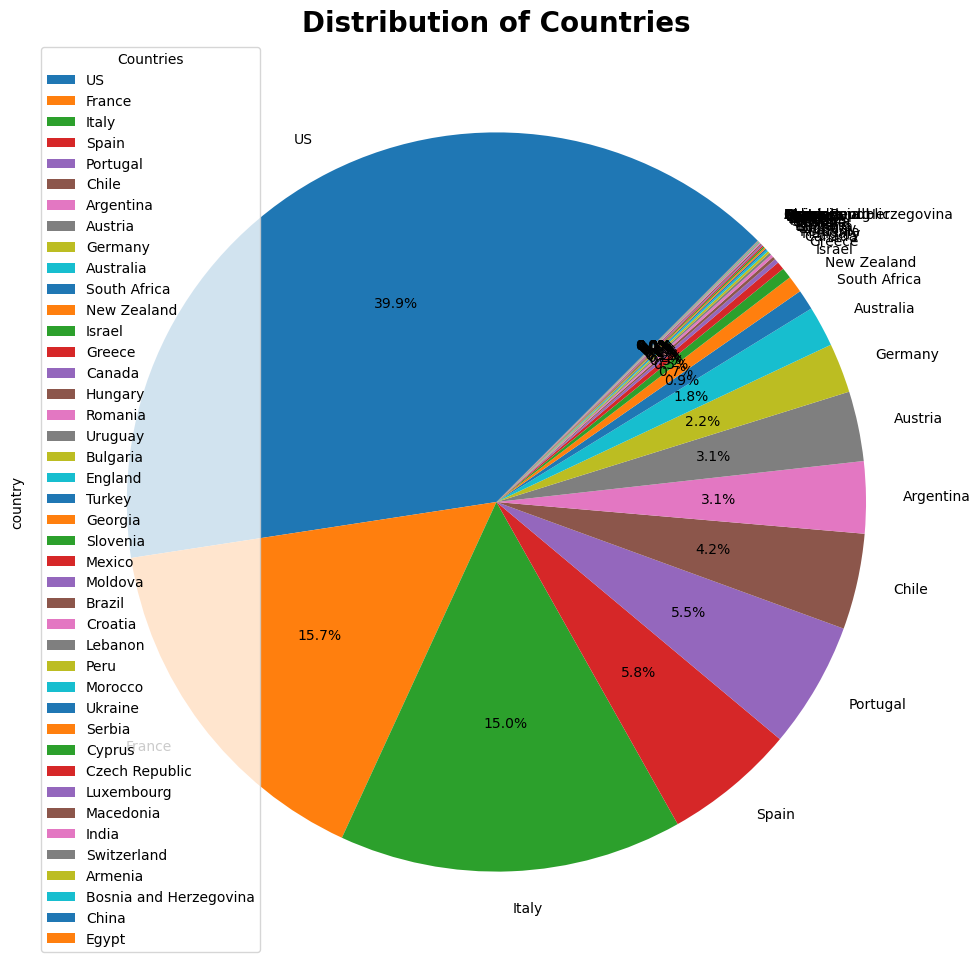

In [19]:
fig = plt.figure(figsize=(12,12))
number_countries = wine['country'].value_counts()
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
plt.legend(title="Countries")
plt.title("Distribution of Countries", fontsize ='20', fontweight = 'bold')
plt.show()

Now, let's look at the **Distribution of variety (grape type)**

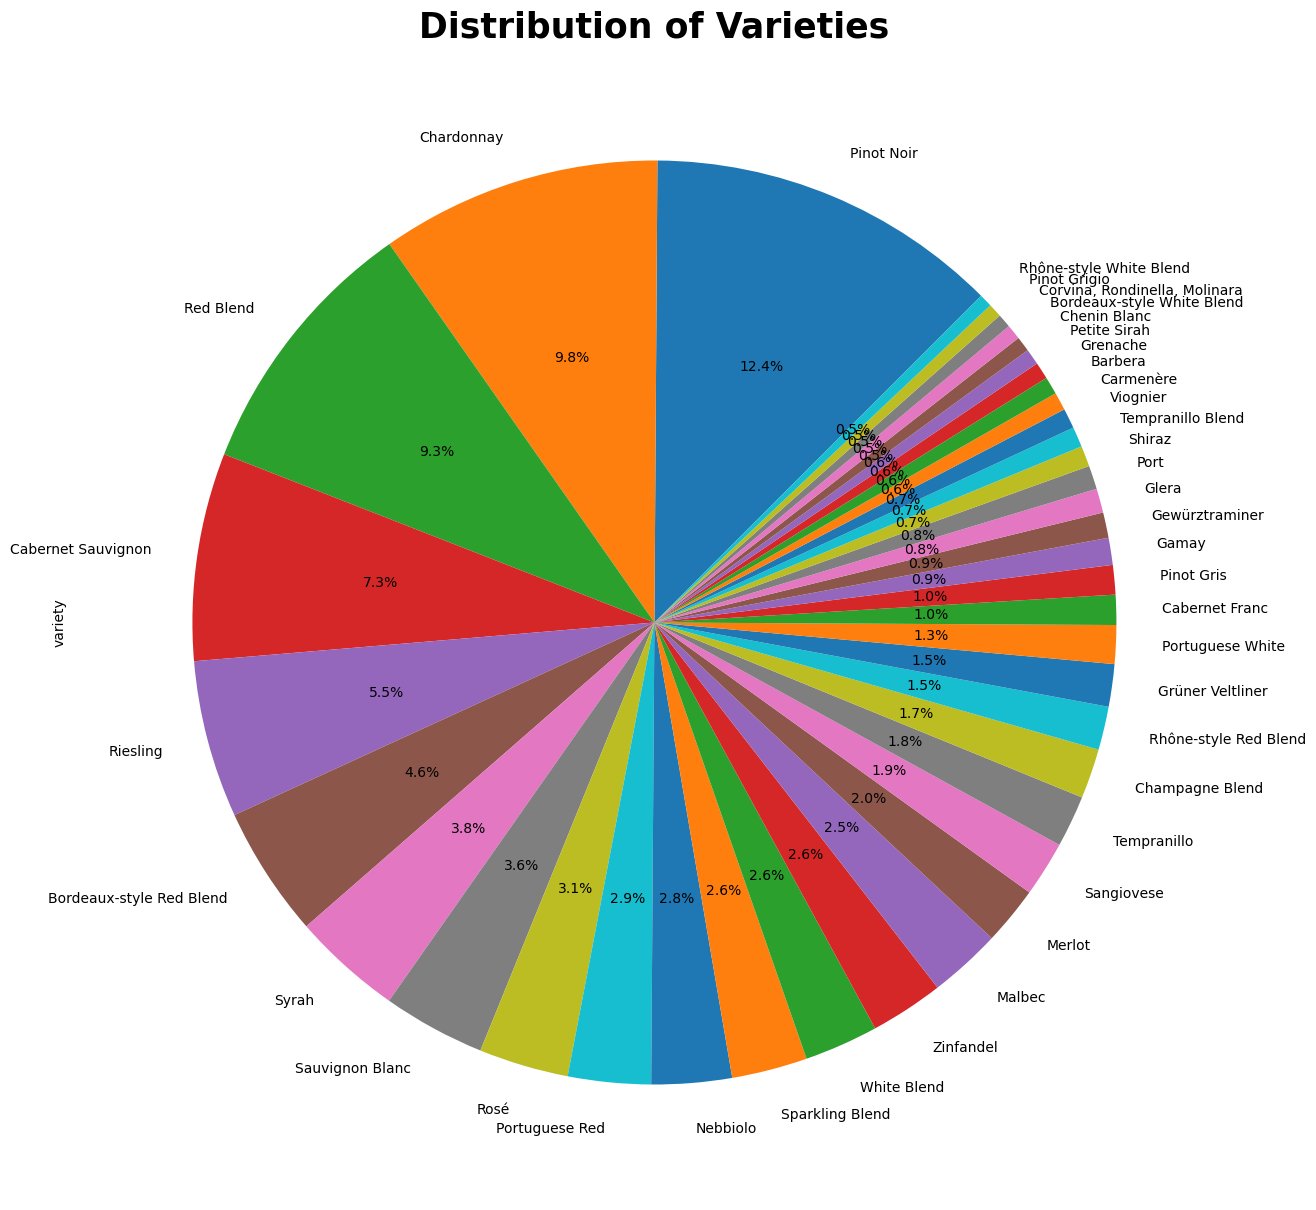

In [20]:
fig = plt.figure(figsize=(15,15))
number_countries = wine['variety'].value_counts()[:40]
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
# plt.legend(title="Varieties")
plt.title("Distribution of Varieties", fontsize ='25', fontweight = 'bold')
plt.show()

Finally, **Distribution of Province** 

In [21]:
province = wine['province'].value_counts()
province

California                 24359
Washington                  5892
Oregon                      3789
Tuscany                     3728
Northern Spain              3077
                           ...  
Vinho da Mesa                  1
Coelemu                        1
Beotia                         1
Piekenierskloof                1
Vin de Pays de Velvendo        1
Name: province, Length: 407, dtype: int64

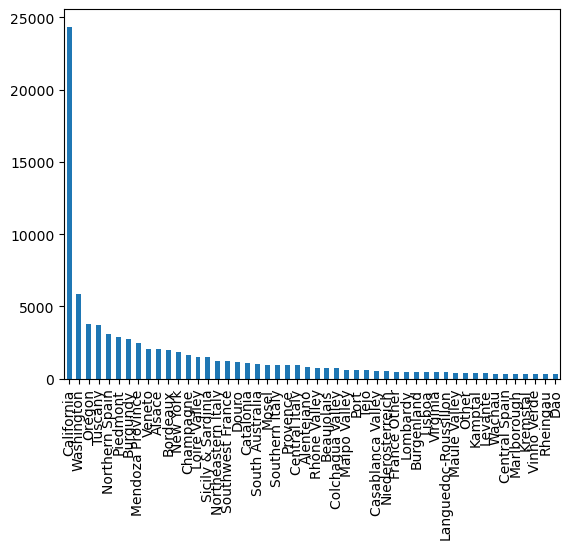

In [22]:
wine['province'].value_counts()[:50].plot(kind = 'bar')

plt.show()